# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair

# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
solutions = '../data'

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, root, file)

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def load_sol_from_dir(folder_path: str, column_list, special_column_name: str = "instance_info"):
    """ Load solutions from directory files into table. """
    it = get_file_paths_from_dir(folder_path, include_sol=True, include_instance=False)
    output_table = None
        
    for (dataset, root, file) in it:
        curr_table = pandas.read_csv(f'{root}/{file}', index_col=None, delimiter=" ", header=None).iloc[:,0:3]
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
        curr_table[special_column_name] = file.split("_")[1]
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    return output_table

def load_data_from_dir(folder_path: str, column_list, special_column_name: str = "instance_info"):
    """ Load data from directory files into table. """
    it = get_file_paths_from_dir(folder_path)
    output_table = None
    
    for (dataset, root, file) in it:
        curr_table = pandas.read_csv(f'{root}/{file}', index_col=None, delimiter=" ", header=None)
        curr_table.columns = column_list
        curr_table["dataset"] = dataset
        curr_table[special_column_name] = file.split("_")[1]
                
        if output_table is not None:
            output_table = output_table.append(curr_table, ignore_index=True)
        else:
            output_table = curr_table
    
    #output_table = output_table.set_index(['algorithm', 'dataset', 'id', "item_count"])
    #output_table.sort_values(by=["algorithm", "dataset", "item_count", "id"], inplace=True)
    return output_table

def construct_table_from(filePair: FilePair):
    solution_table = pandas.read_csv(filePair.solutionFile, header=None, index_col=None, delimiter=" ")
    data_table = pandas.read_csv(filePair.dataFile, header=None, index_col=None, delimiter=" ")
    
    item_count = data_table.iloc[0, 1]
    
    solution_table = solution_table.drop_duplicates(subset=[0], keep='first').reset_index()

    data_table = data_table.iloc[:, 4:]
    data_table = data_table[data_table.columns[::2]]

    info_table = pandas.concat([solution_table.iloc[:, 1], solution_table.iloc[:, 3], data_table.max(axis=1)], axis=1)
    info_table.columns = ["id", "best_value", "max_cost"]
    info_table["item_count"] = item_count
    return info_table

def create_avg_time_table(table, name: str, column_name: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm_name", column_name])['elapsed_time'] \
        .mean().reset_index().set_index(["algorithm_name", column_name])
    avg_times = avg_times.round(2)

    # Move all values of algorithm column into separate columns
    #avg_times = avg_times.unstack("algorithm_name")
    #avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column_name}"
    avg_times.sort_values(by=column_name, inplace=True)
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    #avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error_table(table, column_name: str, table_name: str = "unknown"):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per {column_name}"
    
    
    avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")\
        .round(6)\
        .to_excel(f"excel/{table_name}_avg_error.xlsx", sheet_name=table_name)
    
    return avg_error

In [4]:
# Create column lists

sol_cols = ["id", "item_count", "best_value"]
cols = get_cols_list(f'{path}/column_description.dat')

## Put data from all analysis files into tables

In [5]:
# Load tables of all strategies
#balance_table = load_data_from_dir(f'{path}/Balance', cols) \
#    .rename(columns={'instance_info':'balance'})
#robust_table = load_data_from_dir(f'{path}/Robust', cols) \
#    .drop(columns="instance_info")

nk_table = load_data_from_dir(f'{path}/NK', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/NK', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkc_table = load_data_from_dir(f'{path}/ZKC', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKC', sol_cols).drop(columns="dataset"), on=["id", "item_count"])
zkw_table = load_data_from_dir(f'{path}/ZKW', cols) \
    .drop(columns="things") \
    .merge(load_sol_from_dir(f'{solutions}/ZKW', sol_cols).drop(columns="dataset"), on=["id", "item_count"])


In [6]:
error_nk = create_avg_error_table(nk_table, "item_count")
error_zkc = create_avg_error_table(zkc_table, "item_count")
error_zkw = create_avg_error_table(zkw_table, "item_count")

time_nk = create_avg_time_table(nk_table, name="initial temperature", column_name="item_count")
time_zkc = create_avg_time_table(zkc_table, name="cooling coefficient", column_name="item_count")
time_zkw = create_avg_time_table(zkw_table, name="number of cycles", column_name="item_count")

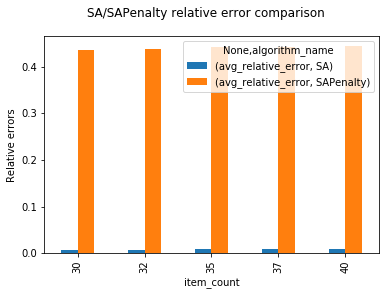

In [7]:
full_table = nk_table.append(zkc_table).append(zkw_table).query("algorithm_name != 'SA_OLD'")
sapenalty_error_comp = create_avg_error_table(full_table, "item_count", "sapenalty_comp")\
    .set_index(["item_count", "algorithm_name"]).unstack("algorithm_name")\
    .drop(columns="max_relative_error")

sapenalty_comp_plot = sapenalty_error_comp.plot.bar(legend=True)
sapenalty_comp_plot.set_ylabel("Relative errors")

figure = sapenalty_comp_plot.get_figure()
figure.suptitle("SA/SAPenalty relative error comparison")
figure.savefig("excel/sapenalty_comp.pdf")

sapenalty_comp_plot

# Parameter analysis
## Analyze the same dataset, change one of the parameters

In [8]:
param_sols = load_sol_from_dir(f'{solutions}/ParamAnalysis', sol_cols) \
    .drop(columns="dataset")

init_temp_table = load_data_from_dir(f'{path}/ParamAnalysis/InitTemperature', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
init_temp_table["init_temp"] = init_temp_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)

cooling_table = load_data_from_dir(f'{path}/ParamAnalysis/Cooling', cols) \
    .drop(columns=["things", "cycles", "min_temperature", "init_temperature"]) \
    .merge(param_sols, on=["id", "item_count"])
cooling_table["cooling_coef"] = cooling_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].str.replace(",", ".").astype(float)

cycles_table = load_data_from_dir(f'{path}/ParamAnalysis/Cycles', cols) \
    .drop(columns=["things", "init_temperature", "min_temperature", "cooling"]) \
    .merge(param_sols, on=["id", "item_count"])
cycles_table["cycles"] = cycles_table["dataset"]\
    .str.split("_", n = 1, expand = True)[1].astype(int)


In [9]:
error_init_temp = create_avg_error_table(init_temp_table, "init_temp")
error_cooling = create_avg_error_table(cooling_table, "cooling_coef")
error_cycles = create_avg_error_table(cycles_table, "cycles")

time_init_temp = create_avg_time_table(init_temp_table, name="initial temperature", column_name="init_temp")
time_cooling = create_avg_time_table(cooling_table, name="cooling coefficient", column_name="cooling_coef")
time_cycles = create_avg_time_table(cycles_table, name="number of cycles", column_name="cycles")


    init_temp algorithm_name  max_relative_error  avg_relative_error
0         100             SA            0.598615            0.017429
3         300             SA            0.598615            0.012486
6         500             SA            0.598615            0.011925
9         700             SA            0.262642            0.009392
12        900             SA            0.262642            0.009207
15       1000             SA            0.238636            0.008769
18       2500             SA            0.262642            0.009268


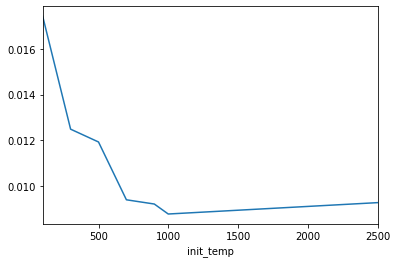

In [10]:
print(error_init_temp.query('algorithm_name == "SA"'))
error_init_temp.query('algorithm_name == "SA"').set_index("init_temp").loc[:, "avg_relative_error"].plot()

    cooling_coef algorithm_name  max_relative_error  avg_relative_error
0          0.875             SA            0.598615            0.014761
3          0.900             SA            0.598615            0.014514
6          0.925             SA            0.598615            0.014749
9          0.950             SA            0.598615            0.013848
12         0.975             SA            0.598615            0.012706


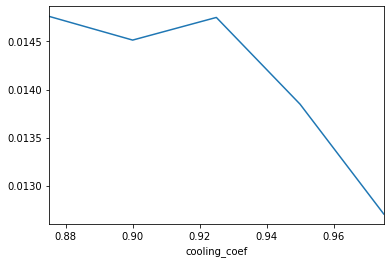

In [11]:
print(error_cooling.query('algorithm_name == "SA"'))
error_cooling.query('algorithm_name == "SA"').set_index("cooling_coef").loc[:, "avg_relative_error"].plot()

    cycles algorithm_name  max_relative_error  avg_relative_error
0       50             SA            0.598615            0.011925
3      100             SA            0.598615            0.011660
6      150             SA            0.598615            0.010922
9      200             SA            0.598615            0.010768
12     250             SA            0.598615            0.010561


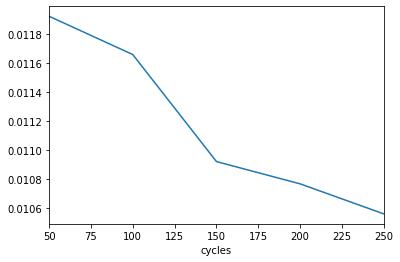

In [12]:
print(error_cycles.query('algorithm_name == "SA"'))
error_cycles.query('algorithm_name == "SA"').set_index("cycles").loc[:, "avg_relative_error"].plot()

# DataAnalysis
## Analyze datasets that were generated differently with fixed SA parameters

In [13]:
dpath = f'{path}/DataAnalysis'
dsolutions = f'{solutions}/DataAnalysis'

balance_table = load_data_from_dir(f'{dpath}/Balance', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/Balance', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'balance'})
correlation_table = load_data_from_dir(f'{dpath}/Correlation', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/Correlation', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'correlation'})
granularity_heavy_table = load_data_from_dir(f'{dpath}/GranularityHeavy', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/GranularityHeavy', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'constant'})
granularity_light_table = load_data_from_dir(f'{dpath}/GranularityLight', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/GranularityLight', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'constant'})
maxcost_table = load_data_from_dir(f'{dpath}/MaxCost', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/MaxCost', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'maxcost'})
maxweight_table = load_data_from_dir(f'{dpath}/MaxWeight', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/MaxWeight', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'maxweight'})
things_table = load_data_from_dir(f'{dpath}/Things', cols)
weight_cap_ratio_table = load_data_from_dir(f'{dpath}/WeightCapRation', cols) \
    .merge(load_sol_from_dir(f'{dsolutions}/WeightCapRation', sol_cols).drop(columns="dataset"), on=["id", "instance_info"])\
    .rename(columns={'instance_info':'ratio'})


In [14]:
error_balance = create_avg_error_table(balance_table, "balance")
error_corr = create_avg_error_table(correlation_table, "correlation")
error_granularity_heavy = create_avg_error_table(granularity_heavy_table, "constant")
error_granularity_light = create_avg_error_table(granularity_light_table, "constant")
error_maxcost = create_avg_error_table(maxcost_table, "maxcost")
error_maxweight = create_avg_error_table(maxweight_table, "maxweight")
error_weightcap = create_avg_error_table(weight_cap_ratio_table, "ratio")

  balance algorithm_name  max_relative_error  avg_relative_error
0     Bal             SA            0.025727            0.002378
2   Heavy             SA            0.026123            0.003208
4   Light             SA            0.018607            0.001916


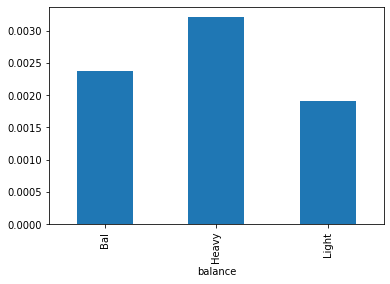

In [15]:
#create_avg_error_table(, "maxcost")
print(error_balance.query('algorithm_name == "SA"'))
error_balance.query('algorithm_name == "SA"').set_index("balance").loc[:, "avg_relative_error"].plot.bar(legend=False)

  correlation algorithm_name  max_relative_error  avg_relative_error
0        Corr             SA            0.050226            0.011334
2      Strong             SA            0.099150            0.025827
4         Uni             SA            0.025727            0.002378


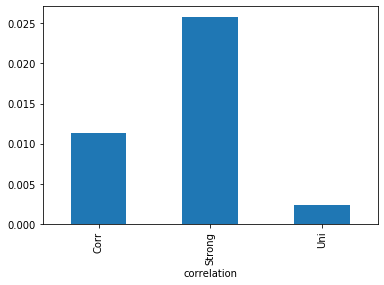

In [16]:
print(error_corr.query('algorithm_name == "SA"'))
error_corr.query('algorithm_name == "SA"').set_index("correlation").loc[:, "avg_relative_error"].plot.bar(legend=False)

   constant algorithm_name  max_relative_error  avg_relative_error
0      0,25             SA            0.029000            0.002715
2       0,5             SA            0.043330            0.003120
4      0,75             SA            0.048144            0.003886
6       1,0             SA            0.044390            0.003554
8      1,25             SA            0.036932            0.003327
10      1,5             SA            0.051107            0.003181
12     1,75             SA            0.044949            0.003494
14      2,0             SA            0.043814            0.003731
16     2,25             SA            0.054303            0.003871
18      2,5             SA            0.047495            0.004176
20     2,75             SA            0.054494            0.003580
22      3,0             SA            0.043160            0.003220


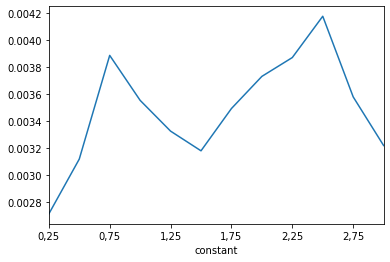

In [17]:
print(error_granularity_heavy.query('algorithm_name == "SA"'))
error_granularity_heavy.query('algorithm_name == "SA"').set_index("constant").loc[:, "avg_relative_error"].plot()

   constant algorithm_name  max_relative_error  avg_relative_error
0      0,25             SA            0.040238            0.002551
2       0,5             SA            0.025884            0.002713
4      0,75             SA            0.036612            0.002585
6       1,0             SA            0.043293            0.002205
8      1,25             SA            0.029449            0.002221
10      1,5             SA            0.037118            0.002277
12     1,75             SA            0.037134            0.001906
14      2,0             SA            0.029145            0.001754
16     2,25             SA            0.029145            0.001954
18      2,5             SA            0.027108            0.001447
20     2,75             SA            0.022679            0.001576
22      3,0             SA            0.023689            0.001457


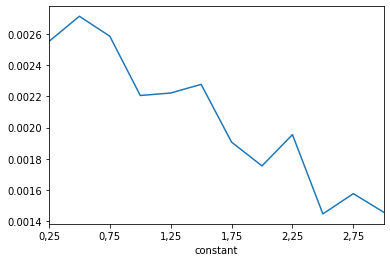

In [18]:
print(error_granularity_light.query('algorithm_name == "SA"'))
error_granularity_light.query('algorithm_name == "SA"').set_index("constant").loc[:, "avg_relative_error"].plot()

  maxcost algorithm_name  max_relative_error  avg_relative_error
0     100             SA            0.026097            0.002011
2     200             SA            0.025595            0.002096
4     300             SA            0.025814            0.001929
6     400             SA            0.025633            0.002104
8     500             SA            0.025525            0.002068


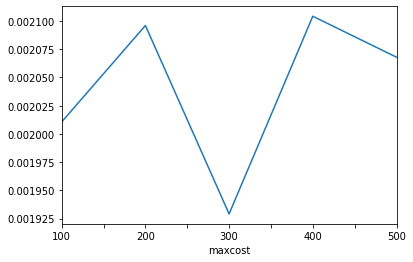

In [19]:
print(error_maxcost.query('algorithm_name == "SA"'))
error_maxcost.query('algorithm_name == "SA"').set_index("maxcost").loc[:, "avg_relative_error"].plot()

  maxweight algorithm_name  max_relative_error  avg_relative_error
0       100             SA            0.025727            0.001990
2       200             SA            0.025727            0.002054
4       300             SA            0.025727            0.002041
6       400             SA            0.025727            0.002071
8       500             SA            0.025727            0.002064


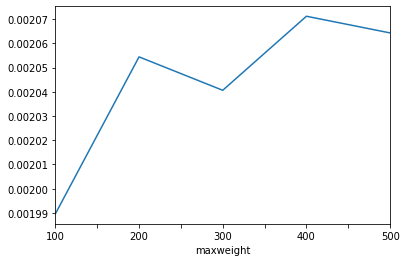

In [20]:
print(error_maxweight.query('algorithm_name == "SA"'))
error_maxweight.query('algorithm_name == "SA"').set_index("maxweight").loc[:, "avg_relative_error"].plot()

   ratio algorithm_name  max_relative_error  avg_relative_error
0    0,1             SA            0.189723            0.015350
2    0,2             SA            0.079602            0.013243
4    0,3             SA            0.083864            0.010652
6    0,4             SA            0.055927            0.009395
8    0,5             SA            0.064094            0.006825
10   0,6             SA            0.055953            0.006206
12   0,7             SA            0.043534            0.003763
14   0,8             SA            0.025727            0.002378
16   0,9             SA            0.028646            0.001950
18   1,0             SA            0.000000            0.000000


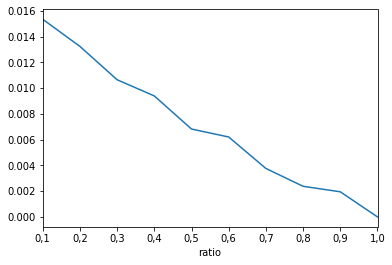

In [21]:
print(error_weightcap.query('algorithm_name == "SA"'))
error_weightcap.query('algorithm_name == "SA"').set_index("ratio").loc[:, "avg_relative_error"].plot()